# Contrast Grid

<div style="text-align: justify">
Applefy provides two methods for calculating detection limits: **Analytical Contrast Curves** and **Contrast Grids**.

This tutorial focuses on contrast grids, which are more computationally demanding, but yield more intuitive and reliable results. In addition, they are not limited to being used with linear PSF subtraction techniques (such as PCA).

Contrast Grids indicate whether a planet would be detected based on its planet-to-star flux ratio and separation from the host star. All tests described in [the statistics subpackage](../03_package/statistics.rst) can be used for the calculation. The result of a contrast grid **can be transformed into contrast curves** through thresholding.

</div>

<div style="text-align: justify">
The following plot gives an example of a contrast grid computed with applefy. The image on the left shows a residual image obtained with PCA showing a fake planet. On the right the actual contrast grid is shown. The red box in the contrast grid marks the brightness and separation of the inserted fake planet. The color of the contrast grid is the detection uncertatinty (FPF) in terms of $\sigma_{N}$. Planets with $> 5 \sigma_{N}$ are easy to see by eye. Planets with less than $3 \sigma_{N}$ are not detectable.
</div>

For more examples see also [Figure 6](../04_apples_with_apples/paper_experiments/06_Contrast_Grid.ipynb).

In [2]:
from IPython.display import HTML
HTML('../_static/contrast_grid_animation.html')

.. attention:: **Click on the GIF animation to load the interactive version of the plot (~70 MB)**

## Imports

In [2]:
from pathlib import Path

import seaborn as sns
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from applefy.detections.contrast import Contrast

from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma, LaplaceBootstrapTest

from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio

## Demonstration Data

The following tutorial shows how to compute contrast grids. The data used can be downloaded [from Zenodo](../01_getting_started.md).

In [3]:
root_dir = Path("/path/to/documentation_demos")

In [4]:
dataset_config = {'file_path': Path('30_data/betapic_naco_lp_LR.hdf5'),
                  'stack_key': "science_no_planet",
                  'psf_template_key': "psf_template",
                  'parang_key': 'header_science_no_planet/PARANG',
                  'dit_psf_template': 0.02019,
                  'fwhm_size' : 4.2, # Diameter in pixel
                  'dit_science': 0.2}

In general we need three data arrays to compute contrast grids:

- The **science sequence**: A 3D array with dimensions (time, x, y)
- A list of **parallactic angles** for Angular Differential Imaging (time)
- A 2D **PSF-template** which is used to insert artificial planets and determine the detection limits.

We load them from the demonstration  data. In order to save computation time we reduce the resolution of the science sequence by cutting around the central star.

In [5]:
# we need the psf template for contrast calculation
science_data, angles, raw_psf_template_data = load_adi_data(
    root_dir/dataset_config["file_path"],
    data_tag=dataset_config["stack_key"],
    psf_template_tag=dataset_config["psf_template_key"],
    para_tag=dataset_config["parang_key"])

dit_psf_template = dataset_config["dit_psf_template"]
dit_science = dataset_config["dit_science"]
fwhm = dataset_config["fwhm_size"]

psf_template = raw_psf_template_data[82:-82, 82:-82]
science_data = science_data[:, 55:-55, 55:-55]

<div class="admonition note"> <p class="admonition-title">For your own data</p> <p>
You can also load your own data from any file format (e.g. .fits). The only requirement is that the data has the right shape. 
    
The **science data needs** to have the dimensions (time, x, y). The image resolution (x, y) has to be **square**. We recommend that the resolution is **odd**.
    
The **psf template** needs to be a 2d array with dimensions (x, y). The image resolution (x, y) has to be **square**. We recommend that the resolution is **odd**. 
    
Both the science data as well as the psf template need to be well centered.
</p> </div>

Here are some examples for how the data looks:

In [6]:
psf_template.shape

(21, 21)

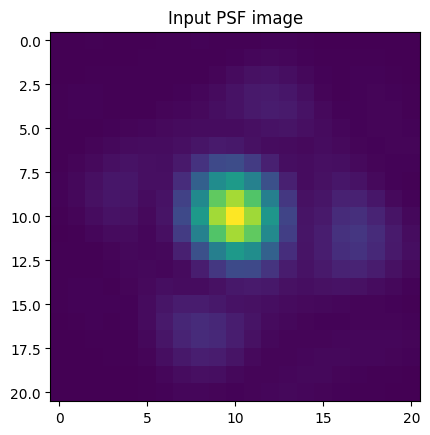

In [7]:
plt.imshow(psf_template)
_=plt.title("Input PSF image")

In [8]:
science_data.shape

(594, 75, 75)

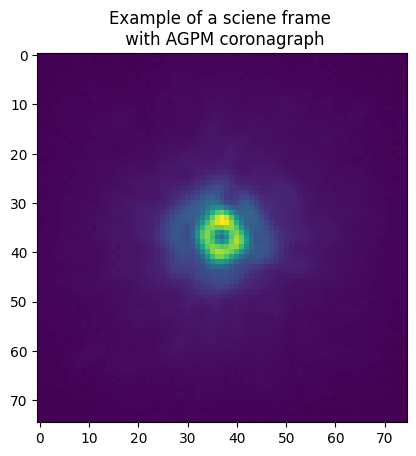

In [9]:
plt.imshow(science_data[0, :, :])
_=plt.title("Example of a sciene frame \n with AGPM coronagraph")

## How to compute a Contrast Grid?

The main interface to calculate analytical contrast curves as well as contrast grids is the class [Contrast](../03_package/detections.rst#applefy.detections.contrast.Contrast). It takes the science sequence, parallactic angles and the PSF-template required to run fake planet experiments. 

It further needs the FWHM of the PSF (can be calculated e.g. with [PynPoint](https://pynpoint.readthedocs.io/en/latest/) or
[VIP](https://vip.readthedocs.io/en/latest/>)) as well as the DIT of both science sequence and PSF-template. 

A checkpoint directroy can be given to store intermediate results (such as residuals). The checkpoint directroy is optional but allows to restore fake planet residuals at a later stage. More information can be found in the [documentation](../03_package/detections.rst#applefy.detections.contrast.Contrast).

In [10]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    scaling_factor=1., # A factor to account e.g. for ND filters
    checkpoint_dir=root_dir / Path("70_results/contrast_grid"))

### Step 1: Design fake planet experiments

In the first step we **choose** at which **separations** and for which **planet brightnesses** we want to insert fake planets. By default, separations are selected in steps of 1 FWHM from the central star to the edge of the image. The brightness of the fake planets have to be selected manually ([more information](../03_package/detections.rst#applefy.detections.contrast.Contrast.design_fake_planet_experiments)).


Note: The resolution we choose in this step will **determine the grid resolution of the contrast grid**.

In [11]:
# fake planet brightness
flux_ratios_mag = np.linspace(7.5, 12, 10)
flux_ratios = mag2flux_ratio(flux_ratios_mag)

print("Brightness of fake planets in mag: " + str(flux_ratios_mag))
print("Planet-to-star flux ratio: " + str(flux_ratios))

Brightness of fake planets in mag: [ 7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12. ]
Planet-to-star flux ratio: [1.00000000e-03 6.30957344e-04 3.98107171e-04 2.51188643e-04
 1.58489319e-04 1.00000000e-04 6.30957344e-05 3.98107171e-05
 2.51188643e-05 1.58489319e-05]


For each cell in the contrast grid we calculate *num_fake_planets* (between min=1 and max=6) planet residuals.

In [12]:
num_fake_planets = 3

contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    overwrite=True)

Overwriting existing config files.


### Step 2: Run fake planet experiments

In the second step we **insert fake planetes** as chosen in the first step. For each planet we **run the data reduction** algorithm to obtain a residual images. Applefy allows to compute contrast grids with different post-processing algorithms. However, it does not come with any implementation of these techniques. Instead, we use existing implementations in packages like
[PynPoint](https://pynpoint.readthedocs.io/en/latest/) or
[VIP](https://vip.readthedocs.io/en/latest/>). See [wrappers](../03_package/wrappers.rst) for more information.

In the following we use a **classical full-frame PCA** to compute the residuals. But, applefy is not limited to this choice and can be used with any other data-reduction algorithm.

Typically, detection limits depend on the choice of post-processing hyper-parameters (e.g. the number of PCA components). Applefy allows you to compute contrast grids for several hyperparameters simultaneously.

**Option 1:** Here is an example of how to use applefy **with PynPoint** (requires a checkpoint_dir).

In [13]:
from applefy.wrappers.pynpoint import MultiComponentPCAPynPoint

In [14]:
components = [5, 10, 20, 30, 50]

Make sure to choose a scratch folder which has a high bandwidth!

In [15]:
algorithm_function = MultiComponentPCAPynPoint(
    num_pcas=components,
    scratch_dir=contrast_instance.scratch_dir,
    num_cpus_pynpoint=1)

**Option 2:** Here is an example of how to use applefy **with VIP**.

In [ ]:
from applefy.wrappers.vip import MultiComponentPCAvip

In [ ]:
algorithm_function = MultiComponentPCAvip(
    num_pcas_tuple=(5, 50, 10))

**Run the fake planet experiments**

Applefy can run multiple fake planet experiments in parallel. If a checkpoint_dir is specified, all residuals will be saved as .fits files. Already existing residuals are restored from the checkpoint_dir. This allows to continue the calculation in case of an error.

In [16]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=algorithm_function,
    num_parallel=32)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:02<00:00, 88.48it/s]


[DONE]


### Step 3: Compute the contrast grid

Once all fake planet experiments are finished we can **compute the contrast grid**. For this we have to choose:
- What is signal and what is noise, i.e. **how do we measure the photometry** of the noise observations and the signal of the fake planets. Applefy allows to use aperture sums and spaced pixel values. A discussion about when to use what is given in [(Bonse et al. 2023)](../05_citation.rst). More details are given in the [documentation](../03_package/utils.rst#applefy.utils.photometry.AperturePhotometryMode).

In [19]:
# Use spaced pixel values
photometry_mode_planet = AperturePhotometryMode(
    "FS", # or "P"
    psf_fwhm_radius=fwhm/2, 
    search_area=0.5)
photometry_mode_noise = AperturePhotometryMode(
    "P", 
    psf_fwhm_radius=fwhm/2)

In [17]:
# Use apertures pixel values
photometry_mode_planet = AperturePhotometryMode(
    "AS", # or "ASS"
    psf_fwhm_radius=fwhm/2, 
    search_area=0.5)

photometry_mode_noise = AperturePhotometryMode(
    "AS",
    psf_fwhm_radius=fwhm/2)

In [18]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

- Which statistical test we want to use i.e. what type of noise we assume for our residual images.

**Option 1:** The classical [t-test](../03_package/statistics.rst#applefy.statistics.parametric.TTest) as discussed in Mawet et al. 2014 (assumes **Gaussian residual noise**).

In [19]:
statistical_test = TTest()

**Option 2:** The [Parametric Bootstrap](../03_package/statistics.rst#applefy.statistics.bootstrapping.LaplaceBootstrapTest) test as discussed in [(Bonse et al. 2023)](../05_citation.rst) (assumes **Laplacian residual noise**). You can download the lookup [from Zenodo](../01_getting_started.md).

In [ ]:
statistical_test = LaplaceBootstrapTest.construct_from_json_file("file/to/lookup_table")

**Compute the contrast grid**

The contrast grid can again be calculated using multiprocessing. The parameter *num_rot_iter* allows to average out the effect of where the planet and noise values are placed on the residual. More information can be found in [Figure 10](../04_apples_with_apples/paper_experiments/10_Rotation.ipynb).

In [20]:
contrast_curves_grid, contrast_grids = contrast_instance.compute_contrast_grids(
    statistical_test=statistical_test,
    num_cores=32,
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    num_rot_iter=20,
    safety_margin=1.0,
    pixel_scale=0.02718)

Computing contrast grid for PCA (005 components)
Computing contrast grid with multiprocessing:
................................................................................[DONE]
Computing contrast grid for PCA (010 components)
Computing contrast grid with multiprocessing:
................................................................................[DONE]
Computing contrast grid for PCA (020 components)
Computing contrast grid with multiprocessing:
................................................................................[DONE]
Computing contrast grid for PCA (030 components)
Computing contrast grid with multiprocessing:
................................................................................[DONE]
Computing contrast grid for PCA (050 components)
Computing contrast grid with multiprocessing:
................................................................................[DONE]


We get two outputs:
- A dict which contains the contrast grids (one for each number of PCA components).
- A Pandas table showing the contrast curves obtained by thresholding the contrast grids.

In [21]:
contrast_curves_grid

,,PCA (005 components),PCA (010 components),PCA (020 components),PCA (030 components),PCA (050 components)
separation [$FWHM$],separation [arcsec],,,,,
1.0,0.114156,inf,inf,inf,inf,inf
2.0,0.228312,inf,inf,inf,inf,inf
3.0,0.342468,inf,0.000541,0.000366,0.000352,0.000367
4.0,0.456624,0.000422,0.000239,0.000215,0.000203,0.000169
5.0,0.570780,0.000212,0.000113,0.000084,0.000079,0.000079
6.0,0.684936,0.000144,0.000097,0.000070,0.000057,0.000060
7.0,0.799092,0.000111,0.000116,0.000082,0.000079,0.000066
8.0,0.913248,0.000094,0.000106,0.000076,0.000062,0.000055


## Plot the Contrast Grid

The following code gives an example for how to plot a contrast grid.

In [22]:
example_grid = contrast_grids["PCA (030 components)"]

# convert FPF to Gaussian Sigma
example_grid = example_grid.applymap(fpf_2_gaussian_sigma) 

# convert flux_ratio to mag
example_grid.index = flux_ratio2mag(example_grid.index)
example_grid

separation [FWHM],1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
flux_ratio,,,,,,,,
7.5,0.467414,3.078834,6.598516,8.260871,9.142012,9.808523,10.298504,10.875756
8.0,-0.196506,2.559208,6.004102,7.406693,8.592544,9.147500,9.695848,10.491602
8.5,-0.406835,2.020826,5.249584,6.550627,8.309442,8.819444,9.291421,10.046024
9.0,-0.543389,1.173240,4.325401,5.534289,7.755116,8.338593,8.532496,9.331370
9.5,-0.604640,0.622541,3.494225,4.374364,6.877012,7.712749,7.211377,8.058577
10.0,-0.655039,0.194433,2.777919,3.207187,5.665348,6.585011,5.779066,6.605511
10.5,-0.687211,-0.086222,2.201652,2.272113,4.339494,5.282271,4.296821,5.043058
11.0,-0.707048,-0.278276,1.764054,1.584575,3.181104,3.990664,3.052231,3.641528
11.5,-0.719374,-0.398379,1.466676,1.102700,2.287226,2.932692,2.133162,2.532781


In [23]:
def plot_contrast_grid(
    contrast_grid_axis,
    colorbar_axis,
    contrast_grid):
    
    c_bar_kargs = dict(
        orientation = "vertical",
        label = r"Confidence [$\sigma_{\mathcal{N}}$]")
    
    heat = sns.heatmap(
        contrast_grid,
        vmax=2, vmin=7, 
        annot=True,
        cmap="YlGnBu",
        ax=contrast_grid_axis,
        cbar_ax=colorbar_axis,
        cbar_kws=c_bar_kargs)
    
    ylabels = ['{:.1f}'.format(float(x.get_text())) 
               for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)

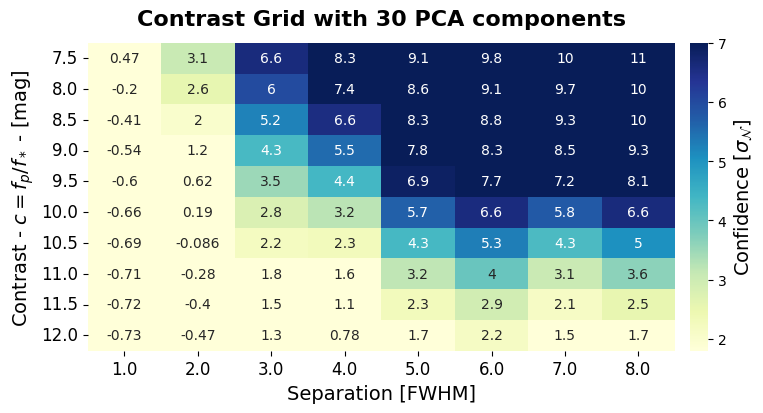

In [24]:
fig = plt.figure(figsize=(8, 4))

gs0 = fig.add_gridspec(1, 1)
gs0.update(wspace=0.0, hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec = gs0[0], 
    wspace=0.05, width_ratios=[1, 0.03])

# All axis we need
contrast_ax = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs1[1])

# Plot the contrast grid
plot_contrast_grid(
    contrast_grid_axis=contrast_ax,
    colorbar_axis=colorbar_ax,
    contrast_grid=example_grid)

colorbar_ax.yaxis.label.set_size(14)

contrast_ax.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
contrast_ax.set_xlabel(
    r"Separation [FWHM]", size=14)
contrast_ax.set_title(
    "Contrast Grid with 30 PCA components", 
    fontsize=16, 
    fontweight="bold", 
    y=1.03)

contrast_ax.tick_params(
    axis='both', 
    which='major', 
    labelsize=12)

# Save the figure
fig.patch.set_facecolor('white')

## Plot the contrast curves

The following code shows how we can plot and compare the contrast curves for different numbers of PCA components.

In [25]:
# compute the overall best contrast curve
overall_best = np.min(contrast_curves_grid.values, axis=1)

In [26]:
# Find one color for each number of PCA components used.
colors = sns.color_palette(
    "rocket_r", 
    n_colors=len(contrast_curves_grid.columns))
colors

[(0.96443322, 0.67025402, 0.51509334),
 (0.94291042, 0.37549479, 0.26369821),
 (0.79085854, 0.10184672, 0.313391),
 (0.51728314, 0.1179558, 0.35453252),
 (0.24525608, 0.10497384, 0.26395596)]

In [27]:
separations_arcsec = contrast_curves_grid.reset_index(level=0).index
separations_FWHM = contrast_curves_grid.reset_index(level=1).index

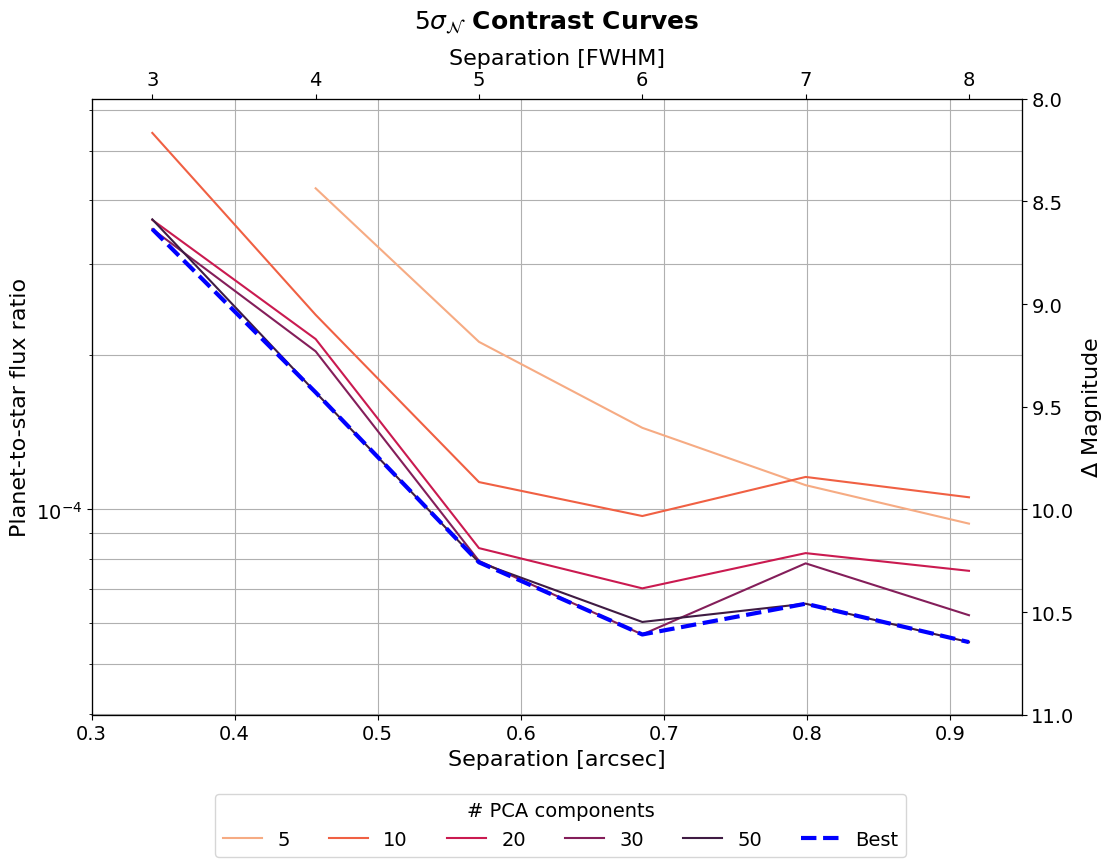

In [28]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(12, 8))
gs0 = fig.add_gridspec(1, 1)
axis_contrast_curvse = fig.add_subplot(gs0[0, 0])


# ---------------------- Create the Plot --------------------
i = 0 # color picker

for tmp_model in contrast_curves_grid.columns:
    
    num_components = int(tmp_model[6:9])
    tmp_flux_ratios = contrast_curves_grid.reset_index(
        level=0)[tmp_model].values
    
    axis_contrast_curvse.plot(separations_arcsec,
                              tmp_flux_ratios,
                              color = colors[i],
                              label=num_components)
    i+=1
    
axis_contrast_curvse.set_yscale("log")
# ------------ Plot the overall best -------------------------
axis_contrast_curvse.plot(
    separations_arcsec,
    overall_best,
    color = "blue",
    lw=3,
    ls="--",
    label="Best")

# ------------- Double axis and limits -----------------------
lim_mag_y = (11, 8)
lim_arcsec_x = (0.3, 0.95)
sep_lambda_arcse = interpolate.interp1d(
    separations_arcsec, 
    separations_FWHM, 
    fill_value='extrapolate')

axis_contrast_curvse_mag = axis_contrast_curvse.twinx()
axis_contrast_curvse_mag.plot(
    separations_arcsec,
    flux_ratio2mag(tmp_flux_ratios),
    alpha=0.)
axis_contrast_curvse_mag.invert_yaxis()

axis_contrast_curvse_lambda = axis_contrast_curvse.twiny()
axis_contrast_curvse_lambda.plot(
    separations_FWHM,
    tmp_flux_ratios,
    alpha=0.)

axis_contrast_curvse.grid(which='both')
axis_contrast_curvse_mag.set_ylim(*lim_mag_y)
axis_contrast_curvse.set_ylim(
    mag2flux_ratio(lim_mag_y[0]), 
    mag2flux_ratio(lim_mag_y[1]))

axis_contrast_curvse.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_mag.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_lambda.set_xlim(
    *sep_lambda_arcse(lim_arcsec_x))

# ----------- Labels and fontsizes --------------------------

axis_contrast_curvse.set_xlabel(
    r"Separation [arcsec]", size=16)
axis_contrast_curvse_lambda.set_xlabel(
    r"Separation [FWHM]", size=16)

axis_contrast_curvse.set_ylabel(
    r"Planet-to-star flux ratio", size=16)
axis_contrast_curvse_mag.set_ylabel(
    r"$\Delta$ Magnitude", size=16)

axis_contrast_curvse.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_lambda.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_mag.tick_params(
    axis='both', which='major', labelsize=14)

axis_contrast_curvse_mag.set_title(
    r"$5 \sigma_{\mathcal{N}}$ Contrast Curves",
    fontsize=18, fontweight="bold", y=1.1)

# --------------------------- Legend -----------------------
handles, labels = axis_contrast_curvse.\
    get_legend_handles_labels()

leg1 = fig.legend(handles, labels, 
                  bbox_to_anchor=(0.22, -0.08), 
                  fontsize=14, 
                  title="# PCA components",
                  loc='lower left', ncol=8)

_=plt.setp(leg1.get_title(),fontsize=14)

As you can see the number of PCA components has a large effect on the contrast curves. We can use our analysis to determine the best number of PCA components as a function of separation.

## Best number of PCA components

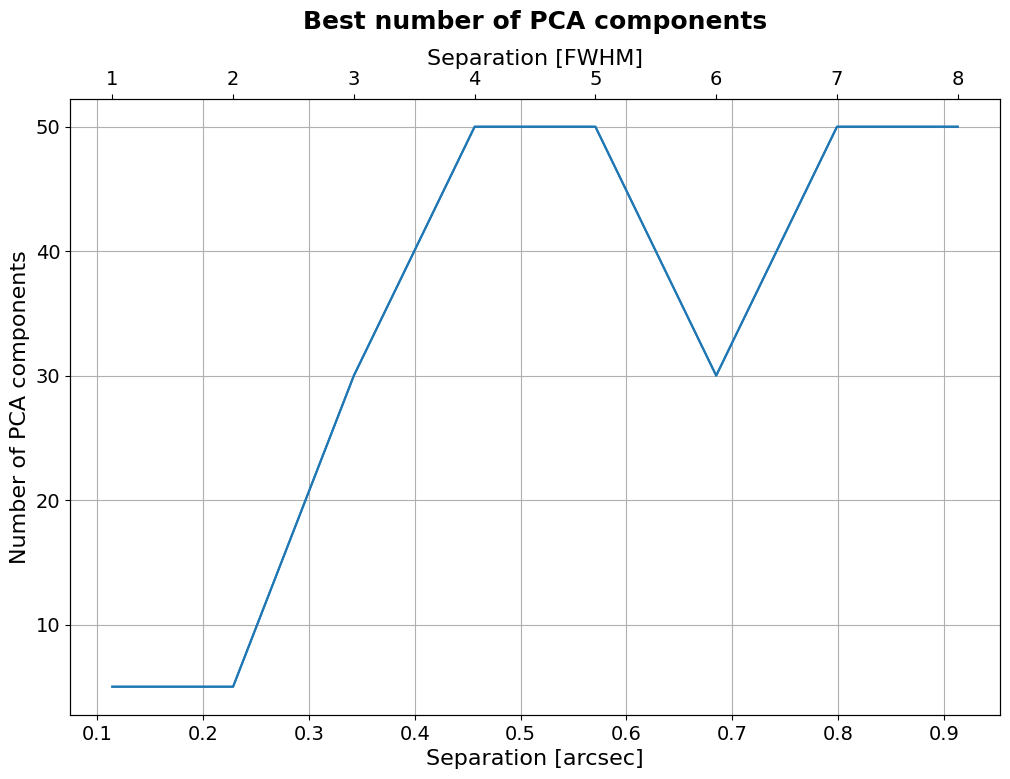

In [29]:
plt.figure(figsize=(12, 8))

plt.plot(separations_arcsec, 
         np.array(components)[np.argmin(
             contrast_curves_grid.values, 
             axis=1)],)

plt.title(r"Best number of PCA components",
          fontsize=18, fontweight="bold", y=1.1)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Separation [arcsec]", fontsize=16)
plt.ylabel("Number of PCA components", fontsize=16)

plt.grid()
ax2 = plt.twiny()
ax2.plot(separations_FWHM, 
         np.array(components)[
             np.argmin(contrast_curves_grid.values, axis=1)],)
ax2.set_xlabel("Separation [FWHM]", fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)